In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [116]:
# Import training set
all_df = pd.read_excel("train.xlsx", index_col=False)

# Drop ID row
all_df.drop("ID", axis=1, inplace=True)

# Remove rows with missing label
index = all_df[all_df["pCR (outcome)"] == 999].index
all_df.drop(index, inplace=True)

# Create y X, removing regression label
y = all_df["pCR (outcome)"]
X = all_df.drop(columns=["RelapseFreeSurvival (outcome)", "pCR (outcome)"])

from sklearn.impute import SimpleImputer
# Replace missing values with median
imputer = SimpleImputer(missing_values=999, strategy="median")
imputer.set_output(transform="pandas")
X = imputer.fit_transform(X)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

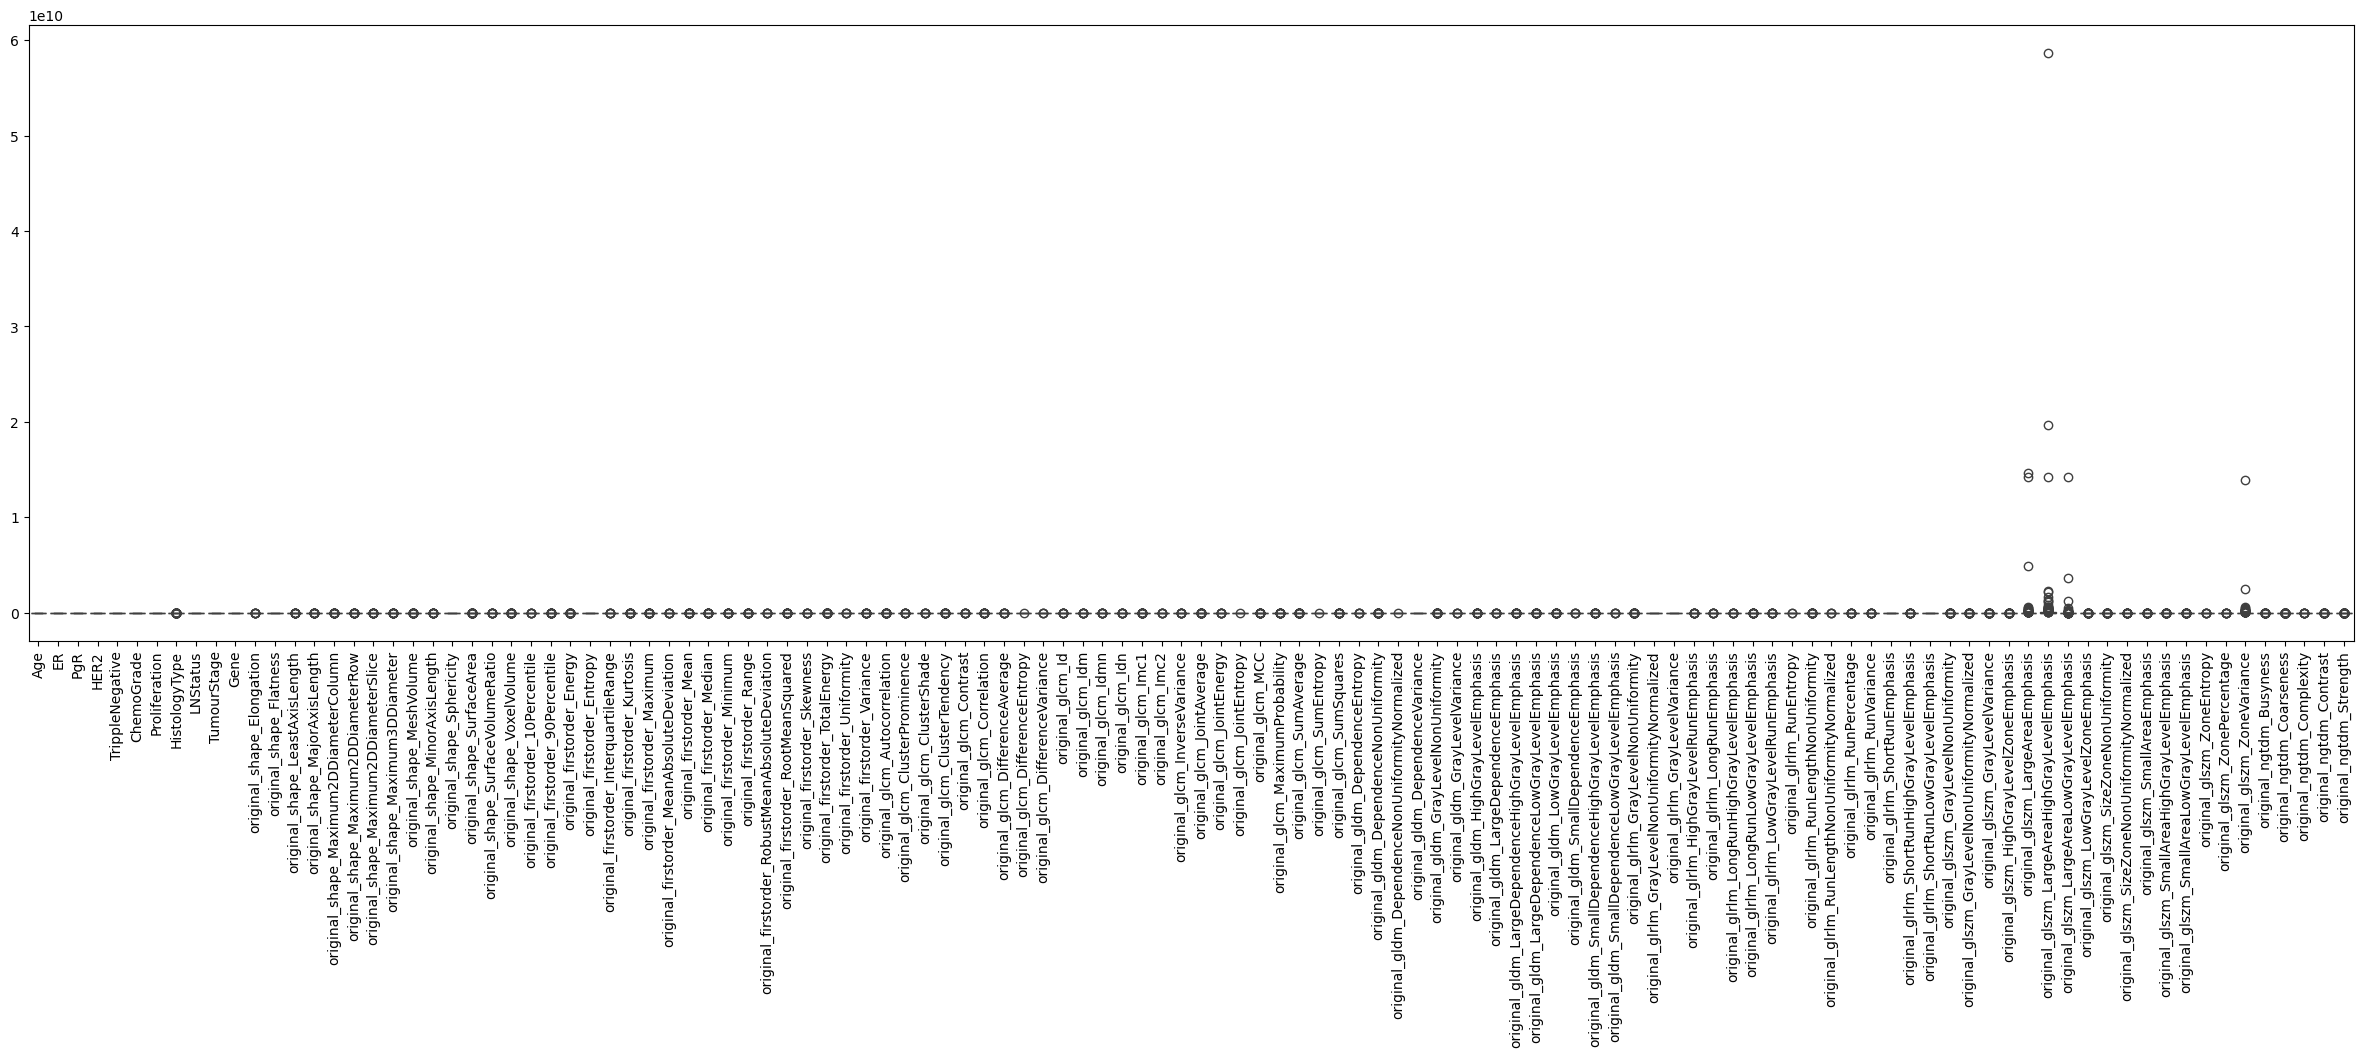

In [117]:
fig,ax = plt.subplots(1,figsize=(30,8))
plot = sns.boxplot(data=X,ax=ax)
plt.setp(plot.get_xticklabels(), rotation=90)

In [118]:
# Replace outliers
import pickle

columns = X.columns
medians = {}
for column in columns:
    medians[column] = X[column].median()

# Save median for inference time
with open('medians.pkl','wb') as f:
    pickle.dump(medians, f)

def replace_outliers(df):
    columns = df.columns
    for column in columns:
        Q1 = df[column].quantile(0.25) 
        Q3 = df[column].quantile(0.75)  
        IQR = Q3 - Q1                  
        lower_bound = Q1 - 1.5 * IQR   
        upper_bound = Q3 + 1.5 * IQR   
        median = medians[column]
        df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)
        
replace_outliers(X)

In [119]:
# Scale features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.set_output(transform="pandas")
Xs = scaler.fit_transform(X)

In [120]:
# Under sample negative pCR response to get even distribution
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=1)
#Xs, y = undersampler.fit_resample(Xs, y)

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.decomposition import PCA

kf = RepeatedKFold(n_splits=4, n_repeats=5, random_state=1)
#model = RandomForestClassifier(random_state=1, n_jobs=-1)
model = MLPClassifier(random_state=1)

#param_grid = {"n_estimators":[1,2,3,4,5,6,7,8,10,20,30,50,70,100,130,170], "criterion":["gini", "entropy", "log_loss"], "max_depth":[1,2,3,4,5,6,7,8,9,10,11], "min_samples_leaf":[1,2,3], "min_samples_split":[2,3,4]}
param_grid = {"hidden_layer_sizes": [(4),(6),(8),(10),(12),(16),(32),(8,4),(8,2),(4,2),(16,8),(16,4)], "activation": ["tanh", "logistic", "relu"], "learning_rate": ["constant", "adaptive", "invscaling"], "max_iter": [100,200,300,400,500]}

# PCA feature reduction
'''
#Xs_important = Xs[["ER","HER2","Gene"]]
#Xs = Xs.drop(columns=["ER","HER2","Gene"])
#pca = PCA(n_components=10)
#pca.set_output(transform="pandas")
#Xs = pca.fit_transform(Xs)
#Xs = Xs_important.join(Xs)

with open("pca_classification.pkl", "wb") as f:
    pickle.dump(pca,f)
'''

kv = GridSearchCV(model, param_grid=param_grid, scoring="balanced_accuracy", cv=kf, n_jobs=-1, refit=True)
kv.fit(Xs,y)

print("Train score" + str(kv.score(Xs,y)))

Train score0.880327279266319


C:\Users\aidan\anaconda3\envs\MLE\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


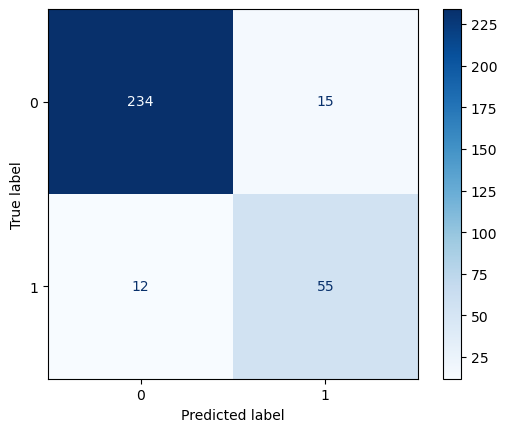

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = kv.predict(Xs)

cm = confusion_matrix(y,predictions)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)

In [127]:
with open("model_classification.pkl", "wb") as f:
    pickle.dump(kv.best_estimator_, f)